# Loading in our data from main.ipynb to build the deeper model

### Loading the data

In [6]:
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

with open("prepared_data.pkl", "rb") as f:
    data = pickle.load(f)

X_train = data["X_train"]
X_val = data["X_val"]
X_test = data["X_test"]
y_train = data["y_train"]
y_val = data["y_val"]
y_test = data["y_test"]
class_weights_dict = data["class_weights"]
num_classes = data["num_classes"]

### Data Augmentation

### Building the model

In [7]:
def build_cnn(num_classes):
    model = Sequential([
        Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        Conv2D(128, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        Conv2D(256, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])

    return model

### Parameters

In [8]:
model = build_cnn(num_classes)

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         6,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,428,632 (5.45 MB)

 Trainable params: 1,427,224 (5.44 MB)

 Non-trainable params: 1,408 (5.50 KB)

### Data augmentation

In [9]:
batch_size = 64
epochs = 50

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(5000)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

### Training the model

In [10]:
print("Training the model...")

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    class_weight=class_weights_dict,
    verbose=1
)

print("Evaluating on test set...")

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Training the model...
Epoch 1/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.2108 - loss: 2.4921 - val_accuracy: 0.3204 - val_loss: 2.2239
Epoch 2/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.3971 - loss: 1.6859 - val_accuracy: 0.3771 - val_loss: 2.0722
Epoch 3/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4781 - loss: 1.4517 - val_accuracy: 0.5332 - val_loss: 1.4720
Epoch 4/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5256 - loss: 1.3151 - val_accuracy: 0.5545 - val_loss: 1.4243
Epoch 5/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5539 - loss: 1.2449 - val_accuracy: 0.5897 - val_loss: 1.2869
Epoch 6/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5806 - loss: 1.1537 - val_accuracy: 0.5943 - val_loss: 1.5015
Epoch 7/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5966 - loss: 1.1031 - val_accuracy: 0.6193 - val_loss: 1.2149
Epoch 8/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6038 - lo

### Plotting Training History

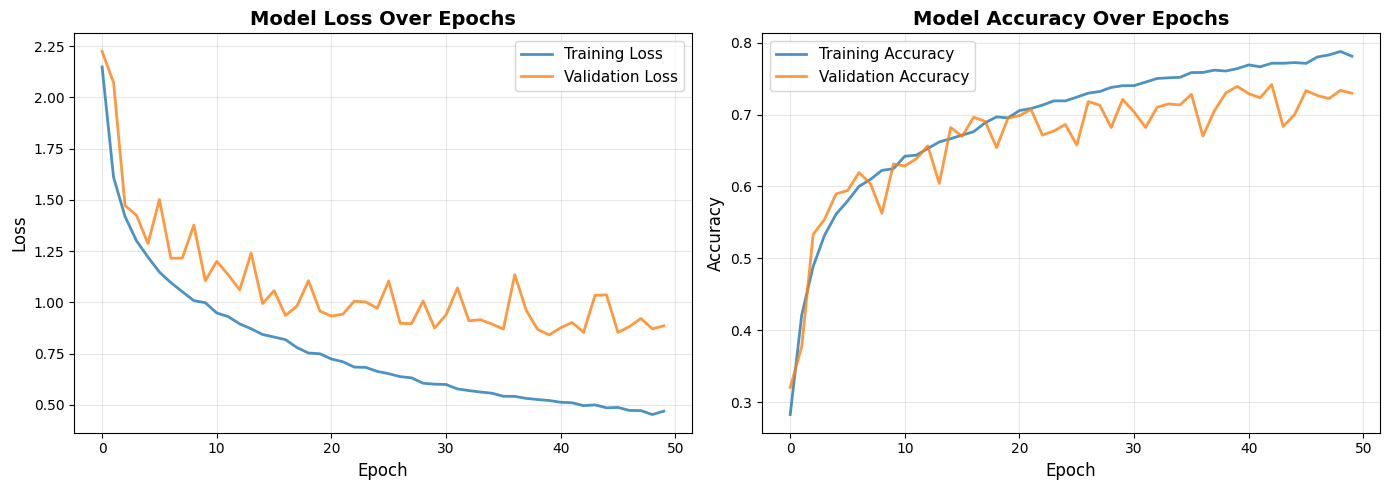

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# loss
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, alpha=0.8)
ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, alpha=0.8)
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, alpha=0.8)
ax2.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Testing with images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


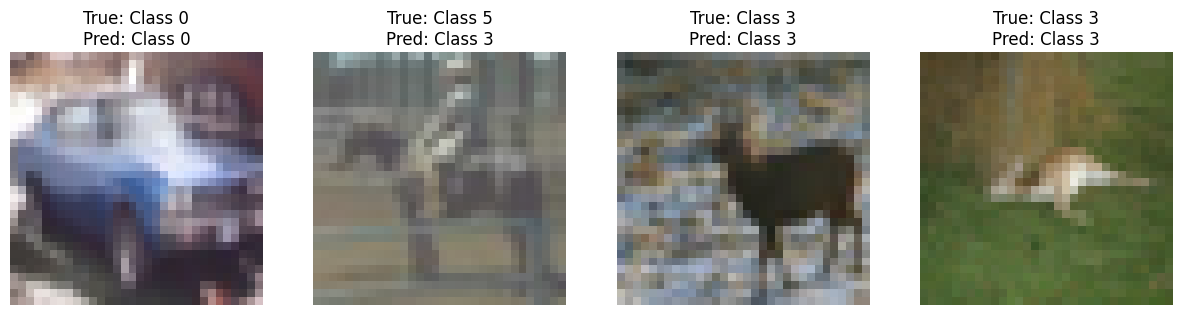

In [13]:
class_names = [f"Class {i}" for i in range(num_classes)]

num_samples = 4
random_indices = np.random.choice(len(X_test), size=num_samples, replace=False)

plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):
    image = X_test[idx]
    true_label = y_test[idx]

    pred_probs = model.predict(np.expand_dims(image, axis=0))
    pred_label = np.argmax(pred_probs)

    plt.subplot(1, num_samples, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")

plt.show()
